In [138]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance_metrics import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance_metrics as perf
import trend_following as tf
%matplotlib inline

In [140]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)

<module 'trend_following' from '/Users/adheerchauhan/Documents/git/trend_following/trend_following.py'>

In [142]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper functions to help pull the data and run the analysis

### Moving Average and Donchian Channels Signals

In [10]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance, ticker):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'{ticker} Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'{ticker} Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'{ticker} Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    # Generate Trend Signal
    if use_coinbase_data:
        df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = tf.get_close_prices(start_date, end_date, ticker, print_status=False)
    df_trend = (tf.create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Signal
    df_donchian = tf.calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                            rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)
    if price_or_returns_calc == 'price':

        # Buy signal: Price crosses above upper band
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))
    elif price_or_returns_calc == 'returns':
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'{ticker}_pct_returns'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_returns']), 1,
            np.where((df_donchian[f'{ticker}_pct_returns'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_returns']), -1, 0))

    # Merging the Trend and donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    if include_signal_strength:
        # Calculate the strength of moving average crossover and donchian signal
        df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'] = (df_trend[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] -
                                                                             df_trend[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'])
        donchian_strength = (np.abs(df_trend[f'{ticker}'] - df_trend[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}']) /
                             df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'])
        crossover_strength = np.abs(df_trend[f'{ticker}_{fast_mavg}_mavg'] - df_trend[f'{ticker}_{slow_mavg}_mavg']) / df_trend[f'{ticker}']

        df_trend[f'{ticker}_crossover_donchian_signal_strength'] = (donchian_strength + crossover_strength) / 2
        strength_threshold = 0.5
    
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1) &
                      (df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1) &
                       ((df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold)))
    else:
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1))
    
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def moving_avg_crossover_with_donchian_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                           rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    performance_rows = []
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for mavg_stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df_trend = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type, price_or_returns_calc,
                                                                         rolling_donchian_window, include_signal_strength, long_only, use_coinbase_data)
                    performance_metrics = calculate_risk_and_performance_metrics(
                        df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                        strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                        annual_trading_days=365, transaction_cost_est=0.005)
                    performance_rows.append({
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': mavg_stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    })
                    # df_performance = df_performance.append(row, ignore_index=True)
    # Convert the list of rows to a DataFrame
    df_performance = pd.DataFrame(performance_rows, columns=perf_cols)
    
    plot_moving_avg_crossover_performance(df_performance, ticker)
    
    return df_performance

In [12]:
def calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc='price', position_size_rolling_atr_window=20,
                                 use_coinbase_data=True):
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose', f'{ticker}_volume']

    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        # df[f'{ticker}_{rolling_atr_window}_ema_price'] = df['close'].ewm(span=rolling_atr_window,
        #                                                                  adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
        df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_true_range_price'] = df[
            [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Calculate Middle Line as the EMA of returns
        df[f'{ticker}_{rolling_atr_window}_ema_returns'] = df[f'{ticker}_pct_returns'].ewm(span=rolling_atr_window,
                                                                                           adjust=False).mean()

        # Calculate True Range based on absolute returns
        df[f'{ticker}_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_ema_returns'].abs()

        # Calculate ATR using the EMA of the True Range
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_true_range_returns'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    return df

In [14]:
## In Sample Performance
# in_sample_start_date = pd.Timestamp(2014, 9, 17).date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2022, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2023, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2024, 9, 30).date()
full_sample_start_date = pd.Timestamp(2014, 9, 17).date()
full_sample_end_date = pd.Timestamp(2024, 9, 30).date()

In [16]:
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=20,
                                     use_coinbase_data=True)

In [17]:
df_atr.head()

,BTC-USD_low,BTC-USD_high,BTC-USD_open,BTC-USD_close,BTC-USD_volume,BTC-USD_high-low,BTC-USD_high-close,BTC-USD_low-close,BTC-USD_true_range_price,BTC-USD_20_avg_true_range_price
date,,,,,,,,,,
2016-01-01,427.92,437.15,430.35,435.66,3863.277451,9.23,NaN,NaN,9.23,9.230000
2016-01-02,432.41,437.56,435.67,435.40,3276.709621,5.15,1.90,3.25,5.15,8.841429
2016-01-03,425.02,435.75,435.40,431.91,3904.335318,10.73,0.35,10.38,10.73,9.021293
2016-01-04,431.37,435.79,431.90,433.85,5894.445723,4.42,3.88,0.54,4.42,8.583074
2016-01-05,430.00,435.64,433.84,433.34,5150.109476,5.64,1.79,3.85,5.64,8.302781


In [17]:
ticker = 'BTC-USD'
rolling_atr_window = 20
df_atr[[f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1).head()

,BTC-USD_20_avg_true_range_price
date,
2016-01-01,NaN
2016-01-02,9.230000
2016-01-03,8.841429
2016-01-04,9.021293
2016-01-05,8.583074


In [18]:
df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, 
                                                       mavg_stepsize=6, rolling_donchian_window=20, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [19]:
trend_cols = ['BTC-USD','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']
df_returns = df_trend[trend_cols]
# df_returns = pd.merge(df_returns, df_atr, left_index=True, right_index=True, how='left')

In [47]:
def get_volatility_scaled_target_position_size(start_date, end_date, ticker, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                               position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, high_volatility_threshold=1.5,
                                               use_coinbase_data=True, price_or_returns_calc='price'):
    ## Calculate the Average True Range
    df = calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, position_size_rolling_atr_window, use_coinbase_data)
    df = df[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price']].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_close'].pct_change()
    df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()
    
    # Annualize the standard deviation
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)
    
    # Shift to avoid lookahead bias
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

    ## Determine if the Volatility Regime is High or Low
    df[f'{ticker}_volatility_regime'] = np.where((df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] > high_volatility_threshold *
                                                  df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'].rolling(window=50).mean()), 'High', 'Low')
    df[f'{ticker}_volatility_regime'] = df[f'{ticker}_volatility_regime'].shift(1)

    ## Calculate Volatility Scaled Target Position
    if position_size_with_atr:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
        # df[f'{ticker}_atr_target_position_notional'] = np.where(df[f'{ticker}_volatility_regime'] == 'High', df[f'{ticker}_atr_target_position_notional'] * 0.5, df[f'{ticker}_atr_target_position_notional'])
    else:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)
        
    ## Cap position size to not exceed initial capital
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].fillna(0)
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].clip(upper=initial_capital)

    ## Shift position sizes by 1 to avoid lookahead bias
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].shift(1)
    
    return df

In [107]:
## Calculate the Average True Range
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=20,
                                     use_coinbase_data=True)
rolling_atr_window=20
ticker = 'BTC-USD'
initial_capital = 15000
risk_per_trade = 0.05
df_atr = df_atr[[f'{ticker}_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1)

## Calculate Annualized Standard Deviation
df_atr[f'{ticker}_pct_returns'] = df_atr[f'{ticker}_close'].pct_change()
position_size_rolling_std_window = 20
position_size_std_multiplier = 50
df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df_atr[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()

# Annualize the standard deviation
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)

# Shift to avoid lookahead bias
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

df_atr[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)

df_atr[f'{ticker}_vol_scaled_target_notional'] = df_atr[f'{ticker}_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_vol_scaled_target_notional'] = df_atr[f'{ticker}_vol_scaled_target_notional'].clip(upper=initial_capital)

## Shift position sizes by 1 to avoid lookahead bias
df_atr[f'{ticker}_vol_scaled_target_notional'] = df_atr[f'{ticker}_vol_scaled_target_notional'].shift(1)

In [111]:
df_atr.head(50)

,BTC-USD_close,BTC-USD_20_avg_true_range_price,BTC-USD_pct_returns,BTC-USD_20_std_dev,BTC-USD_20_annualized_volatility,BTC-USD_vol_scaled_target_notional
date,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,435.66,9.230000,NaN,NaN,NaN,0.000000
2016-01-03,435.40,8.841429,-0.000597,NaN,NaN,0.000000
2016-01-04,431.91,9.021293,-0.008016,NaN,NaN,0.000000
2016-01-05,433.85,8.583074,0.004492,NaN,NaN,0.000000
2016-01-06,433.34,8.302781,-0.001176,NaN,NaN,0.000000
2016-01-07,430.87,8.017755,-0.005700,NaN,NaN,0.000000
2016-01-08,459.07,10.064635,0.065449,NaN,NaN,0.000000
2016-01-09,454.44,10.712765,-0.010086,NaN,NaN,0.000000


In [49]:
def apply_position_sizing_strategy(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                   long_only=False, include_signal_strength=False, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                   position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, use_coinbase_data=True,
                                   high_volatility_threshold=1.5, stop_loss_multiplier=1.5, take_profit_multiplier=3, apply_position_sizing_pyramid=True, position_sizing_pyramid_factor=0.5):

    close_price_col = f'{ticker}'
    t_1_close_price_col = f'{ticker}_t_1'
    signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
    target_position_notional_col = f'{ticker}_vol_scaled_target_notional'
    actual_position_notional_col = f'{ticker}_actual_position_notional'
    actual_position_shares_col = f'{ticker}_actual_position_share_count'
    actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
    atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
    std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'
    
    df = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                     long_only=long_only, include_signal_strength=include_signal_strength)
    trend_cols = [close_price_col, signal_col, returns_col, trades_col]
    df = df[trend_cols]
    df[t_1_close_price_col] = df[close_price_col].shift(1)
    
    df_position = get_volatility_scaled_target_position_size(start_date=start_date, end_date=end_date, ticker=ticker, position_size_with_atr=position_size_with_atr, 
                                                             position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=position_size_atr_multiplier,
                                                             position_size_rolling_std_window=position_size_rolling_std_window, position_size_std_multiplier=position_size_std_multiplier,
                                                             risk_per_trade=risk_per_trade, initial_capital=initial_capital, high_volatility_threshold=high_volatility_threshold,
                                                             use_coinbase_data=use_coinbase_data, price_or_returns_calc=price_or_returns_calc)
    df = pd.merge(df, df_position, left_index=True, right_index=True, how='left')

    if apply_position_sizing_pyramid:
        ## Apply Position Sizing Pyramid Factor
        df[target_position_notional_col] = np.where((df[signal_col] == 1) | (df[signal_col] == -1), df[target_position_notional_col] * (1 + position_sizing_pyramid_factor),
                                                    df[target_position_notional_col])
    df[actual_position_notional_col] = 0.0
    df[actual_position_entry_price_col] = 0.0
    df[actual_position_shares_col] = 0.0
    df['portfolio_value'] = initial_capital
    df['event'] = np.nan
    
    position = 0
    entry_price = None
    
    for i in range(1, len(df)):
        ## Taking a New Long position
        if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Long Position: {df.index[i]}')
            # position = df[position_col][i]
            # entry_price = df[close_price_col][i]
            # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
            # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Long Position'
            
        ## Taking a New Short position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Short Position'
            
        ## Amending an Existing Long Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Amending an Existing Long Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Long Position'
            # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
            
        ## Amending an Existing Short Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Amending an Existing Short Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Short Position'
            
        ## Taking a New Long Position with an Existing Short Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Take a New Long Position with an Existing Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Long with Existing Short Position'
            
        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Take a New Short Position with an Existing Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Short with Existing Long Position'
        
        ## Closing a Long Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Closing a Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i]
            df['event'][i] = 'Closing Long Position'
            
        ## Closing a Short Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Closing a Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + (df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i])
            df['event'][i] = 'Closing Short Position'
    
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
            # print(f'Other: {df_test.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'No Event'
        
        
            
        # elif df[signal_col][i] == -1 and position > 0:
        #     initial_capital += position * (df[close_price_col][i] - entry_price)
        #     position = 0
        #     entry_price = None
        
        # # Stop-loss and take-profit logic
        # if position > 0:
        #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
        #         initial_capital += position * (df[close_price_col][i] - entry_price)
        #         position = 0
        #         entry_price = None
        
        # df.at[df.index[i], 'Capital'] = initial_capital

    return df

In [113]:
# df_strategy_atr = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
#                                                  rolling_donchian_window=20, position_size_with_atr=True)
df_strategy_std = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                 rolling_donchian_window=20, position_size_with_atr=False, position_size_std_multiplier=10)

In [114]:
df_strategy_std.head(20)

,BTC-USD,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_t_1,BTC-USD_close,BTC-USD_20_avg_true_range_price,BTC-USD_pct_returns,BTC-USD_20_std_dev,BTC-USD_20_annualized_volatility,BTC-USD_volatility_regime,BTC-USD_vol_scaled_target_notional,BTC-USD_actual_position_notional,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_share_count,portfolio_value,event
date,,,,,,,,,,,,,,,,,
2016-01-11,449.19,0,-0.0,NaN,NaN,449.99,10.290903,-0.000866,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,NaN
2016-01-12,434.01,0,-0.0,0.0,449.19,449.19,9.955579,-0.001778,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-13,432.77,0,-0.0,0.0,434.01,434.01,10.684571,-0.033794,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-14,430.03,0,-0.0,0.0,432.77,432.77,10.857469,-0.002857,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-15,357.53,0,-0.0,0.0,430.03,430.03,10.515806,-0.006331,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-16,388.70,0,0.0,0.0,357.53,357.53,16.465729,-0.168593,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-17,378.46,0,-0.0,0.0,388.70,388.70,18.714707,0.087181,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-18,384.89,0,0.0,0.0,378.46,378.46,18.741878,-0.026344,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event
2016-01-19,375.27,0,-0.0,0.0,384.89,384.89,18.480747,0.016990,NaN,NaN,Low,0.000000,0.0,0.0,0.0,15000.0,No Event


<Axes: xlabel='date'>

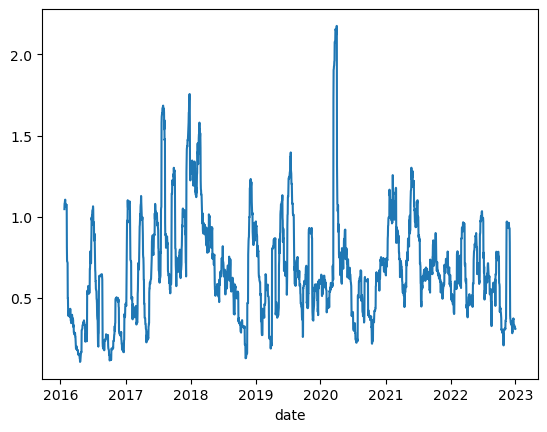

In [117]:
df_strategy_std['BTC-USD_20_annualized_volatility'].plot()

<Axes: xlabel='date'>

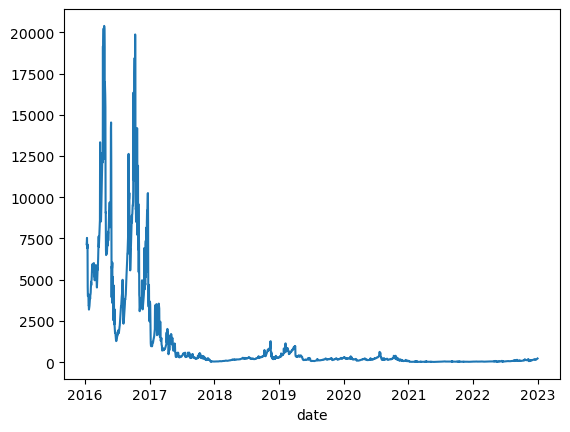

In [119]:
df_strategy_atr['BTC-USD_vol_scaled_target_notional'].plot()

<Axes: xlabel='date'>

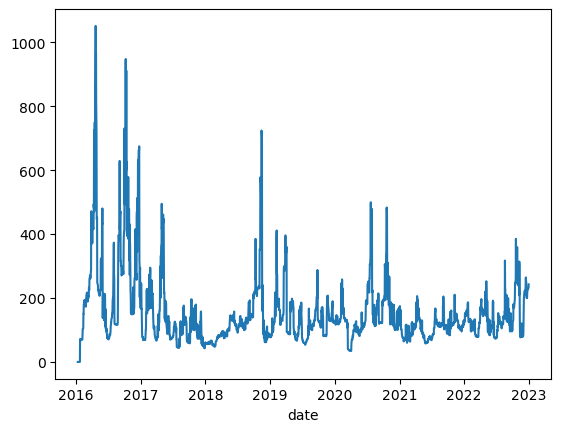

In [121]:
df_strategy_std['BTC-USD_vol_scaled_target_notional'].plot()

In [156]:
def apply_pyramiding(df, ticker, position_col, atr_col, close_col, rolling_atr_window, add_position_atr_multiplier, max_pyramid_levels=3, risk_per_trade=0.05, initial_capital=15000):
    """
    Adjusts the target position by adding to the base position incrementally during a confirmed trend.
    
    Parameters:
    - df: DataFrame containing the price and ATR data.
    - ticker: Ticker symbol.
    - base_position_size: Initial position size.
    - atr_window: Number of periods for ATR calculation.
    - atr_multiplier: ATR-based threshold for adding positions.
    - max_pyramid_levels: Maximum number of incremental adds allowed.
    - risk_per_trade: Risk percentage for each add.
    
    Returns:
    - df with adjusted target positions considering pyramiding.
    """
    # df['current_position'] = base_position_size
    for level in range(1, max_pyramid_levels + 1):
        add_threshold = level * add_position_atr_multiplier * df[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
        df[f'add_level_{level}'] = np.where(
            df[close_col].shift(1) > df[close_col].shift(1).cummax() + add_threshold, 
            df[position_col] * (1 + (level * risk_per_trade)),
            0
        )
        df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[position_col] + df[f'add_level_{level}']

    df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'].clip(upper=initial_capital)
    
    return df

In [160]:
df_strategy = apply_pyramiding(df_strategy, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', close_col=f'{ticker}', rolling_atr_window=20, add_position_atr_multiplier=2)

KeyError: 'BTC-USD_20_avg_true_range_price'

In [154]:
df_position.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_volatility_regime,BTC-USD_vol_scaled_target_notional,low,high,open,close,volume
date,,,,,,,,
2016-01-01,NaN,None,NaN,427.92,437.15,430.35,435.66,3863.277451
2016-01-02,9.230000,Low,0.000000,432.41,437.56,435.67,435.40,3276.709621
2016-01-03,8.841429,Low,1625.135428,425.02,435.75,435.40,431.91,3904.335318
2016-01-04,9.021293,Low,1696.558410,431.37,435.79,431.90,433.85,5894.445723
2016-01-05,8.583074,Low,1662.732915,430.00,435.64,433.84,433.34,5150.109476


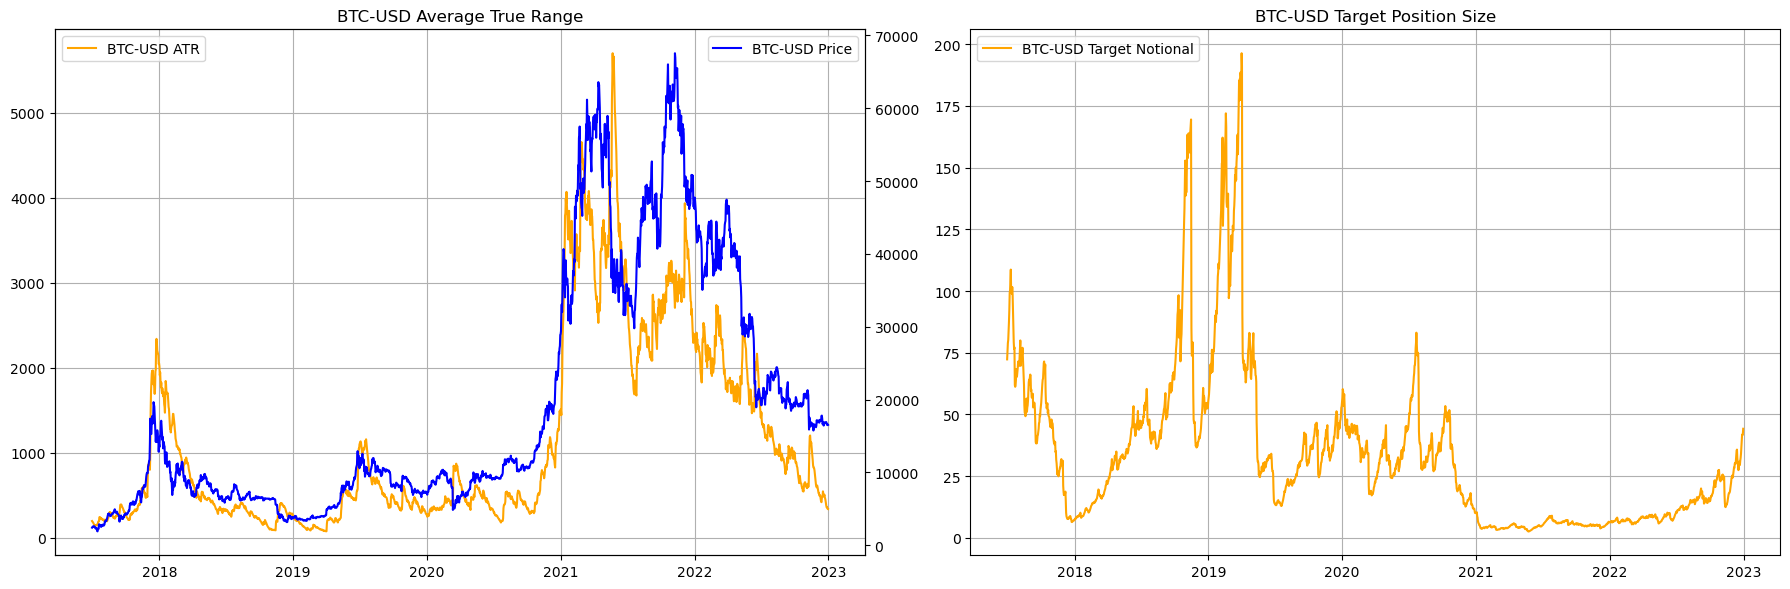

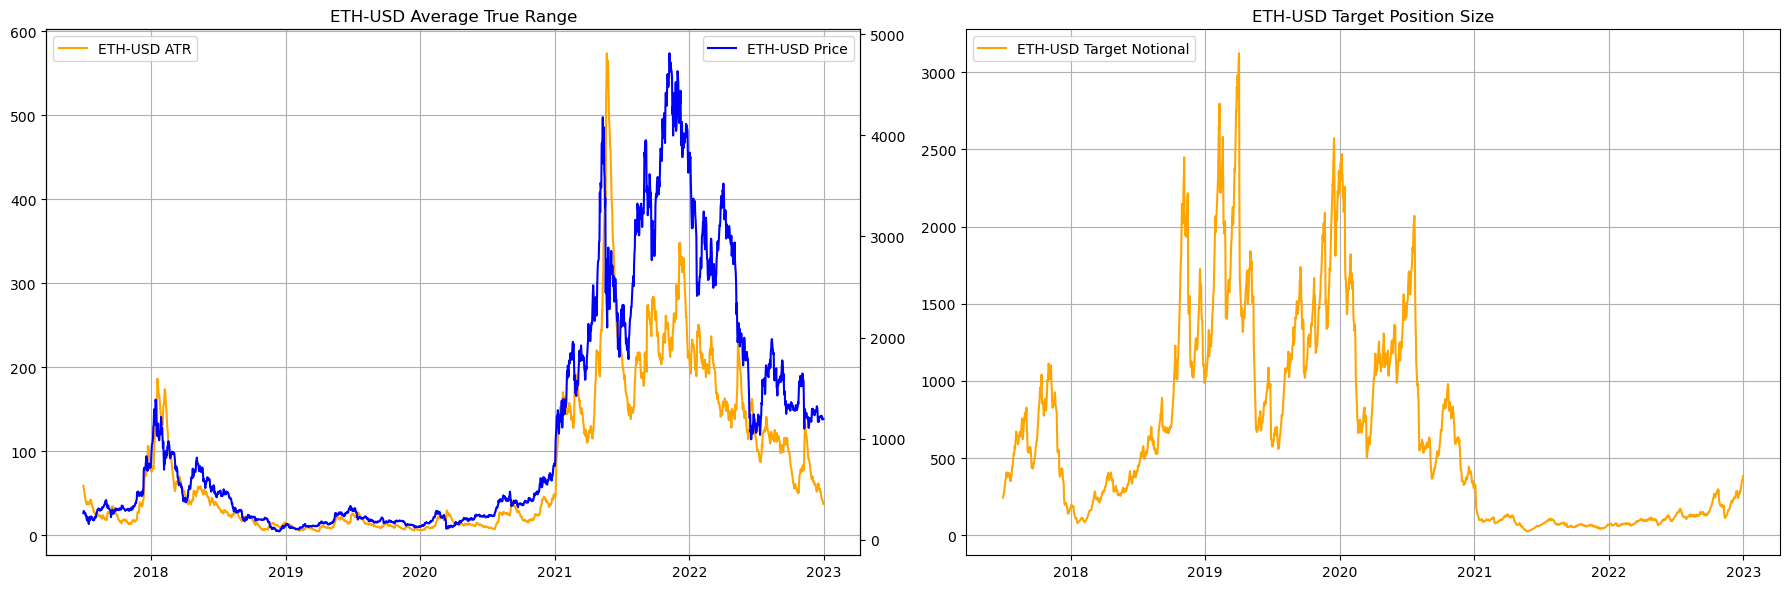

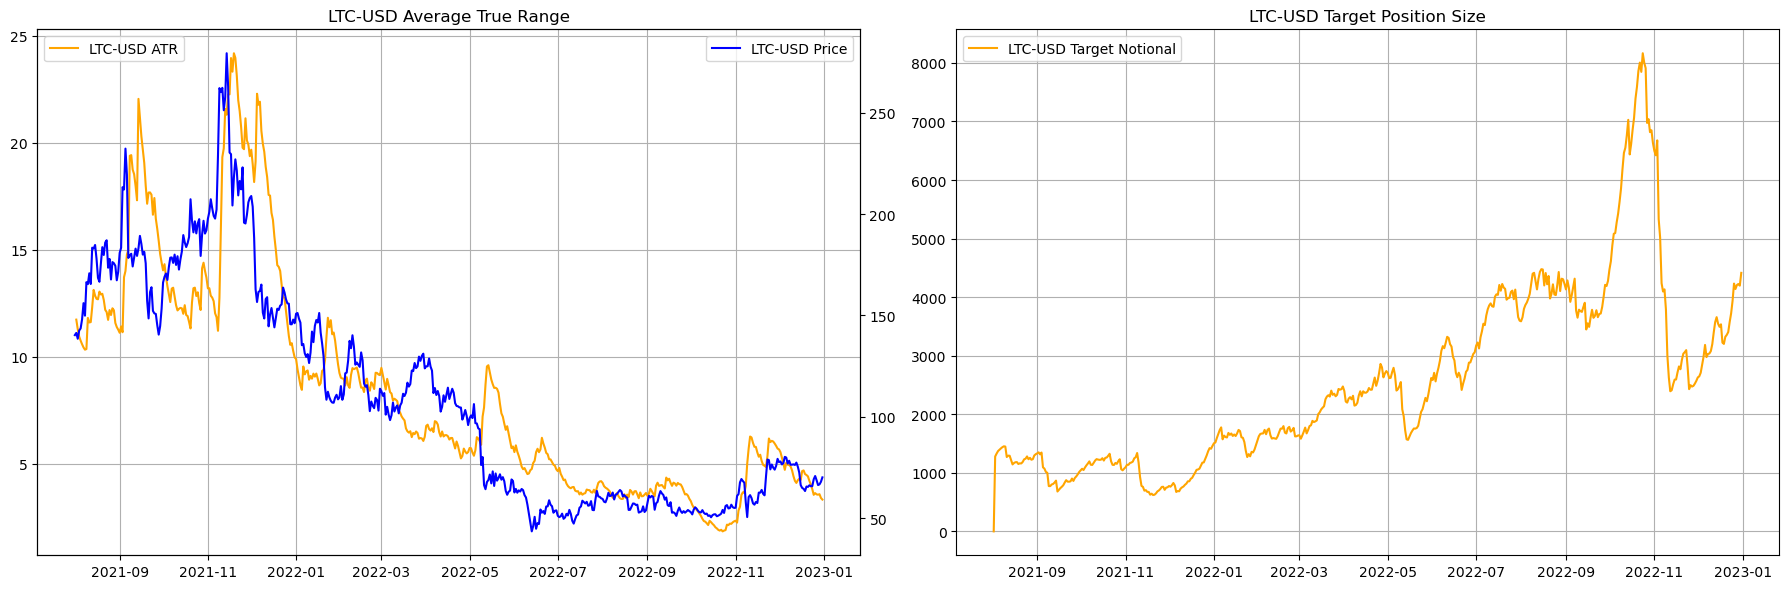

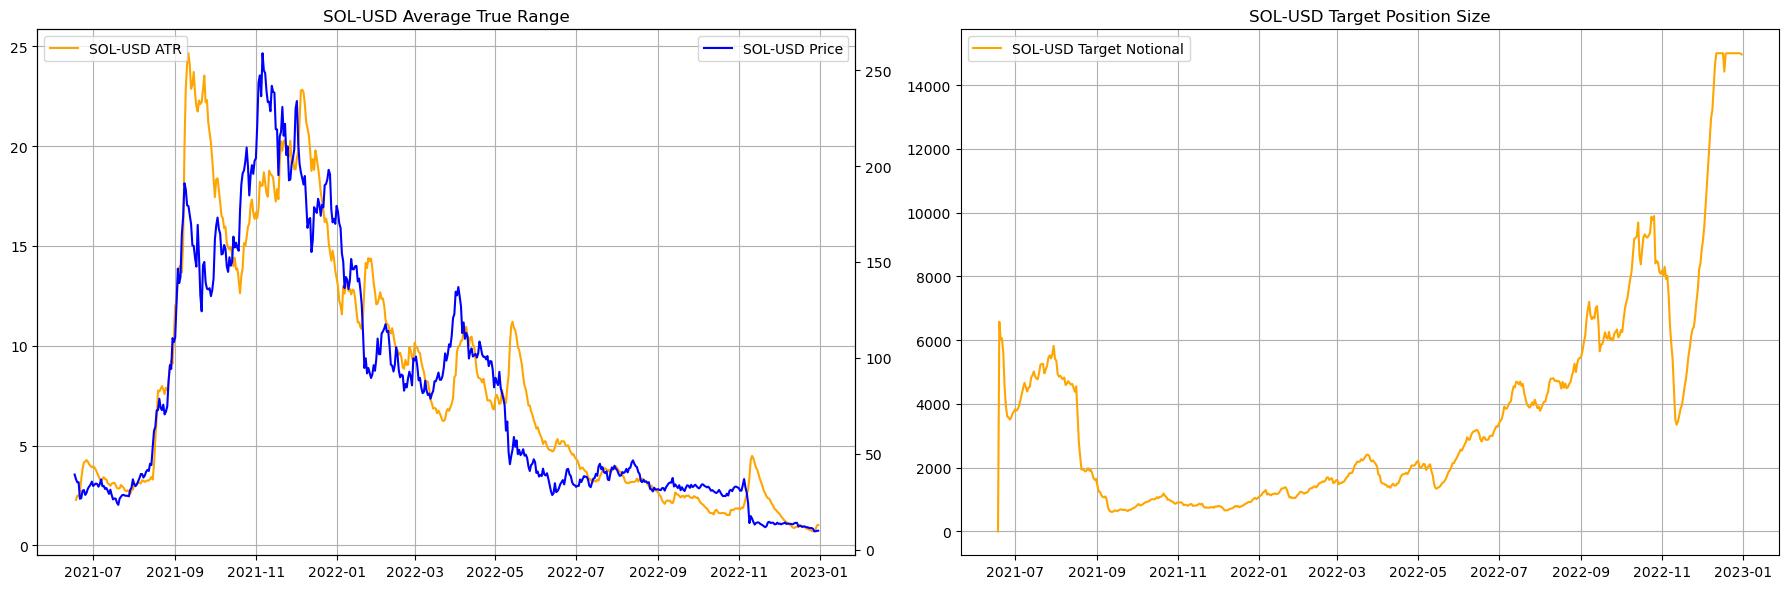

In [131]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=True, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [146]:
df_position[['SOL-USD_20_annualized_volatility','SOL-USD_pct_returns']].corr()

,SOL-USD_20_annualized_volatility,SOL-USD_pct_returns
SOL-USD_20_annualized_volatility,1.000000,0.030043
SOL-USD_pct_returns,0.030043,1.000000


In [150]:
df_position[['SOL-USD_20_avg_true_range_price','SOL-USD_pct_returns']].corr()

,SOL-USD_20_avg_true_range_price,SOL-USD_pct_returns
SOL-USD_20_avg_true_range_price,1.000000,0.013363
SOL-USD_pct_returns,0.013363,1.000000


In [152]:
df_position.head()

,SOL-USD_close,SOL-USD_20_avg_true_range_price,SOL-USD_pct_returns,SOL-USD_20_std_dev,SOL-USD_20_annualized_volatility,SOL-USD_volatility_regime,SOL-USD_vol_scaled_target_notional,low,high,open,close,volume
date,,,,,,,,,,,,
2021-06-17,NaN,NaN,NaN,NaN,NaN,None,NaN,38.219,40.500,40.500,39.250,202117.954
2021-06-18,39.250,2.281000,NaN,NaN,NaN,Low,0.0,35.000,39.450,39.321,36.842,471361.712
2021-06-19,36.842,2.487571,-0.061350,NaN,NaN,Low,0.0,34.977,37.361,36.875,35.200,263002.615
2021-06-20,35.200,2.477707,-0.044569,NaN,NaN,Low,0.0,31.324,35.954,35.200,35.271,287189.023
2021-06-21,35.271,2.682688,0.002017,NaN,NaN,Low,0.0,26.000,35.532,35.286,26.625,836374.380


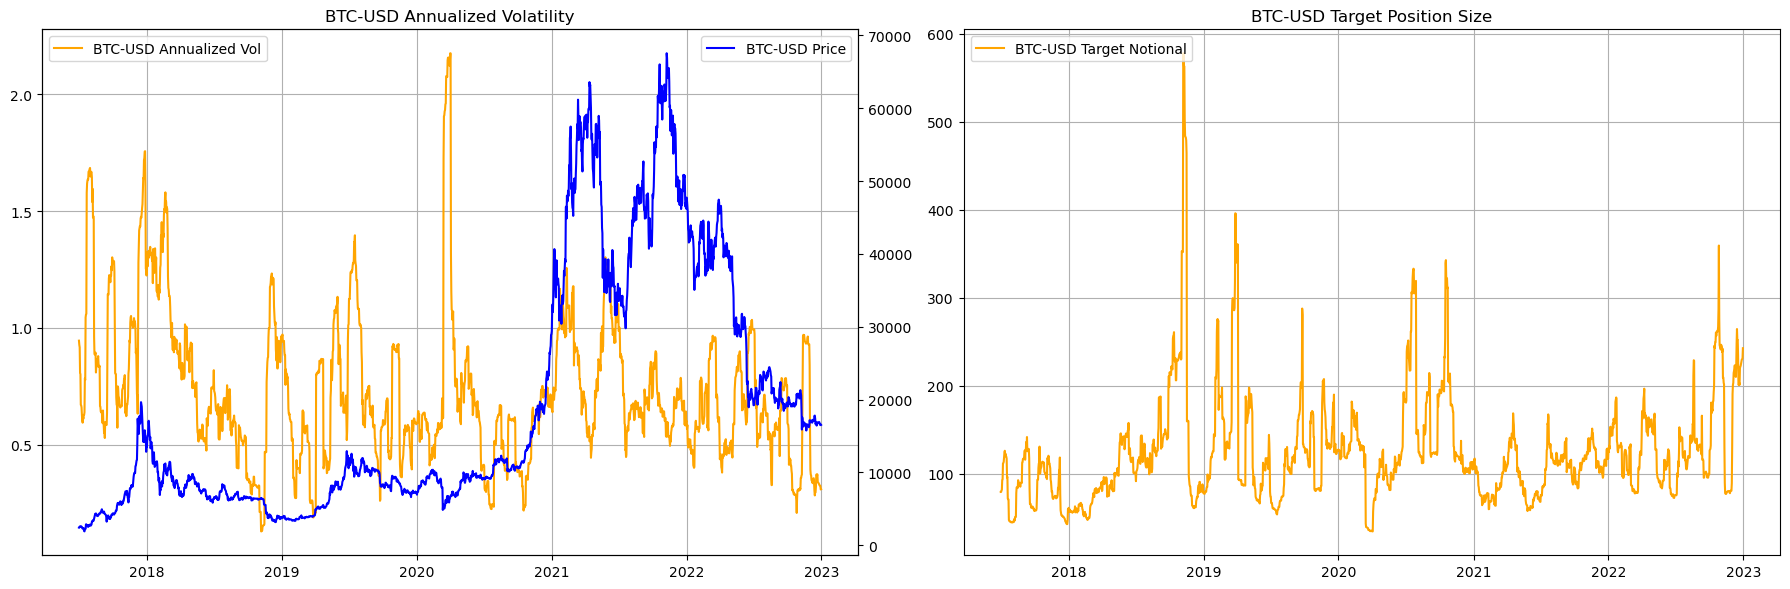

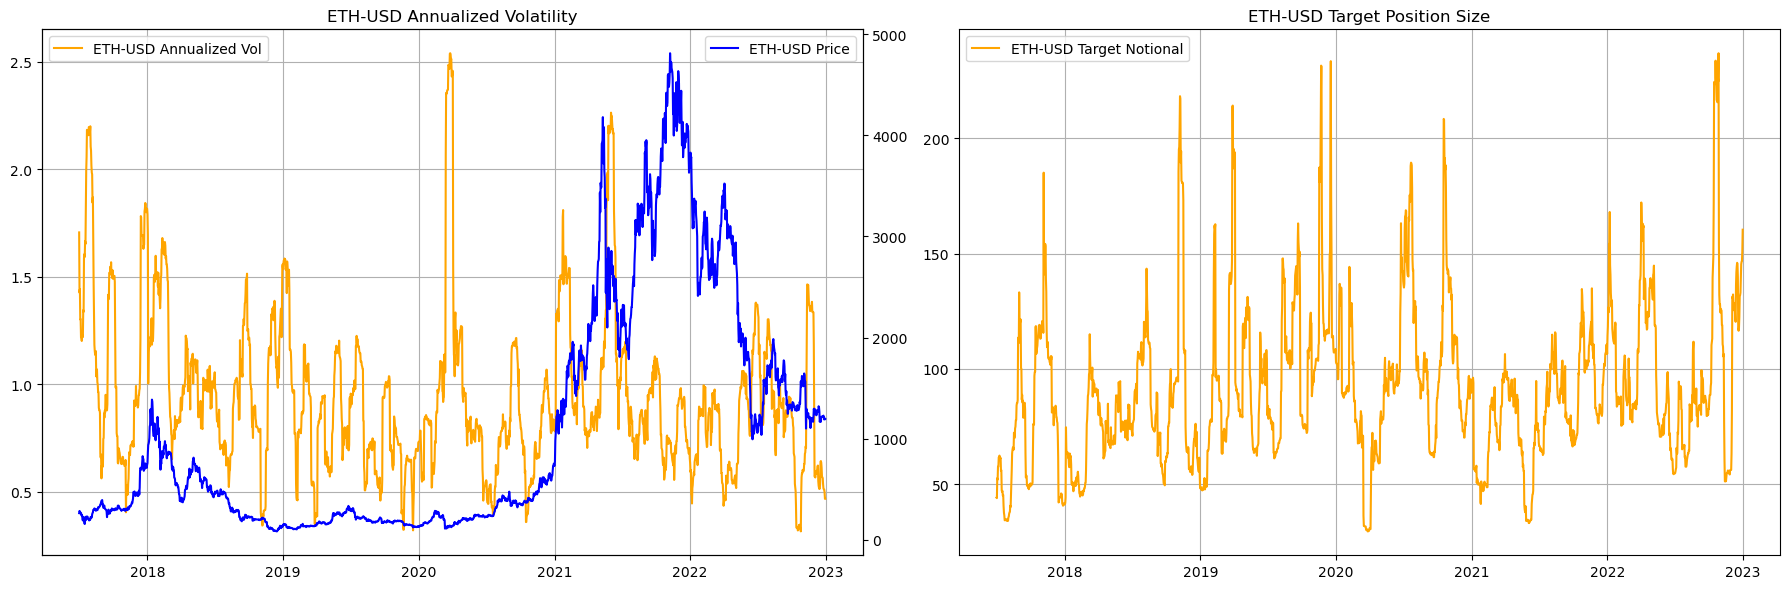

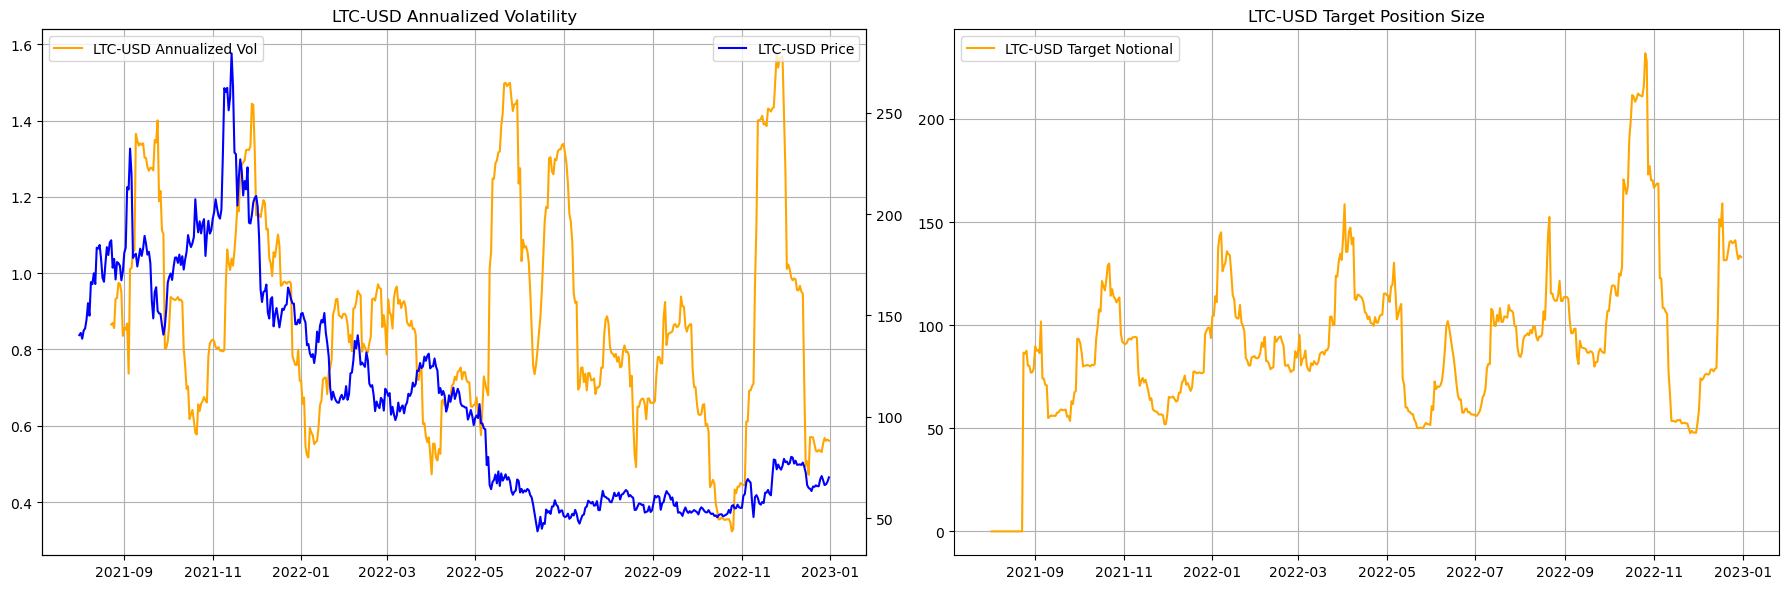

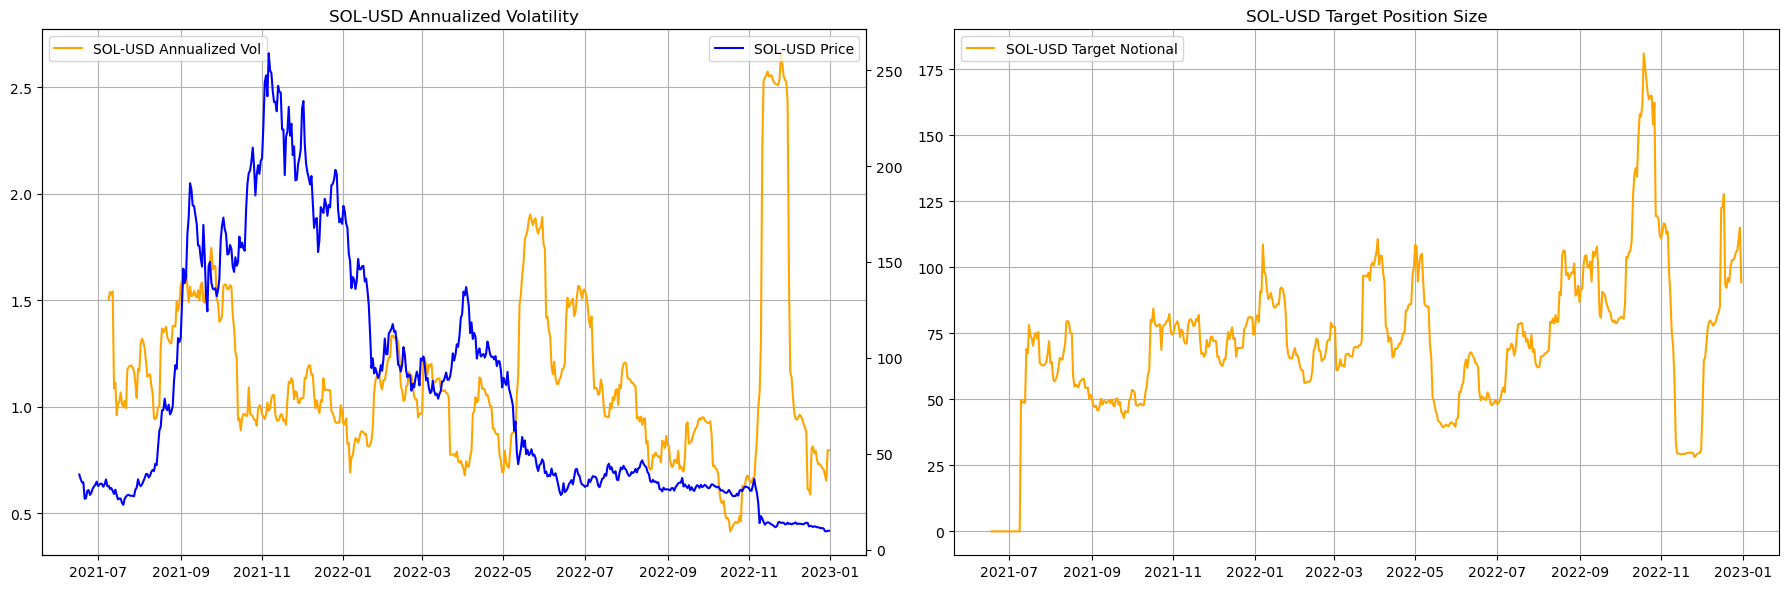

In [135]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=False, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price',
    # rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_annualized_volatility'], label=f'{ticker} Annualized Vol', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Annualized Volatility')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [92]:
short_position_event_list = ['New Short Position', 'Existing Short Position']
df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                              df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                              df_strategy['portfolio_value'])
df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()

# Calculate rolling mean and standard deviation for 50-day intervals
rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=50).mean()
rolling_std = df_strategy['strategy_pct_returns'].rolling(window=50).std()

# Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
df_strategy[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

In [74]:
# Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
annualization_factor = 365  # number of trading days in a year
sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
print("Overall Sharpe Ratio:", sharpe_ratio)

Overall Sharpe Ratio: 1.1319204847100126


BTC-USD Overall Sharpe Ratio: 0.29848351587462507
ETH-USD Overall Sharpe Ratio: 0.4681914115432054
LTC-USD Overall Sharpe Ratio: 1.1029935688001309
SOL-USD Overall Sharpe Ratio: 1.1319204847100124


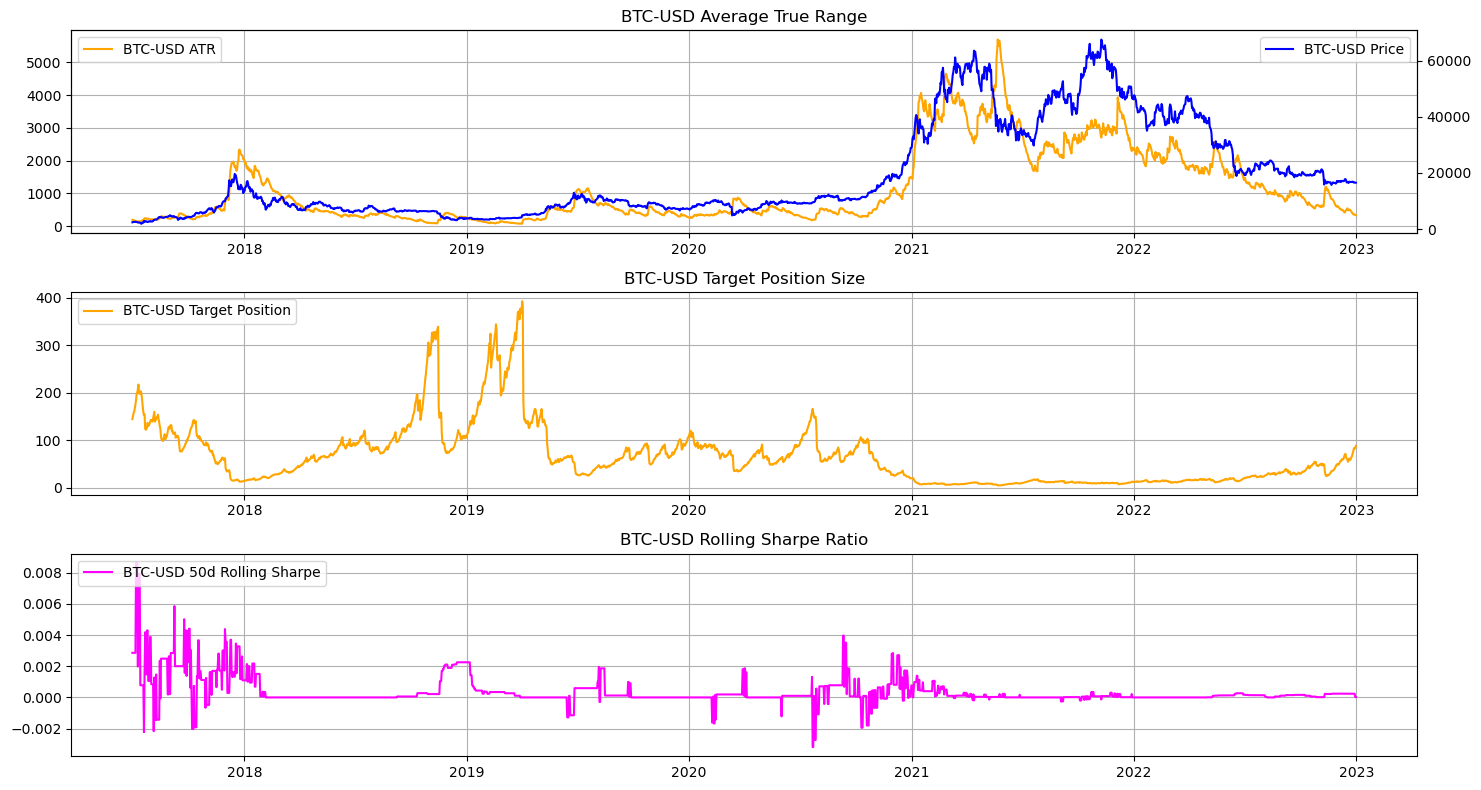

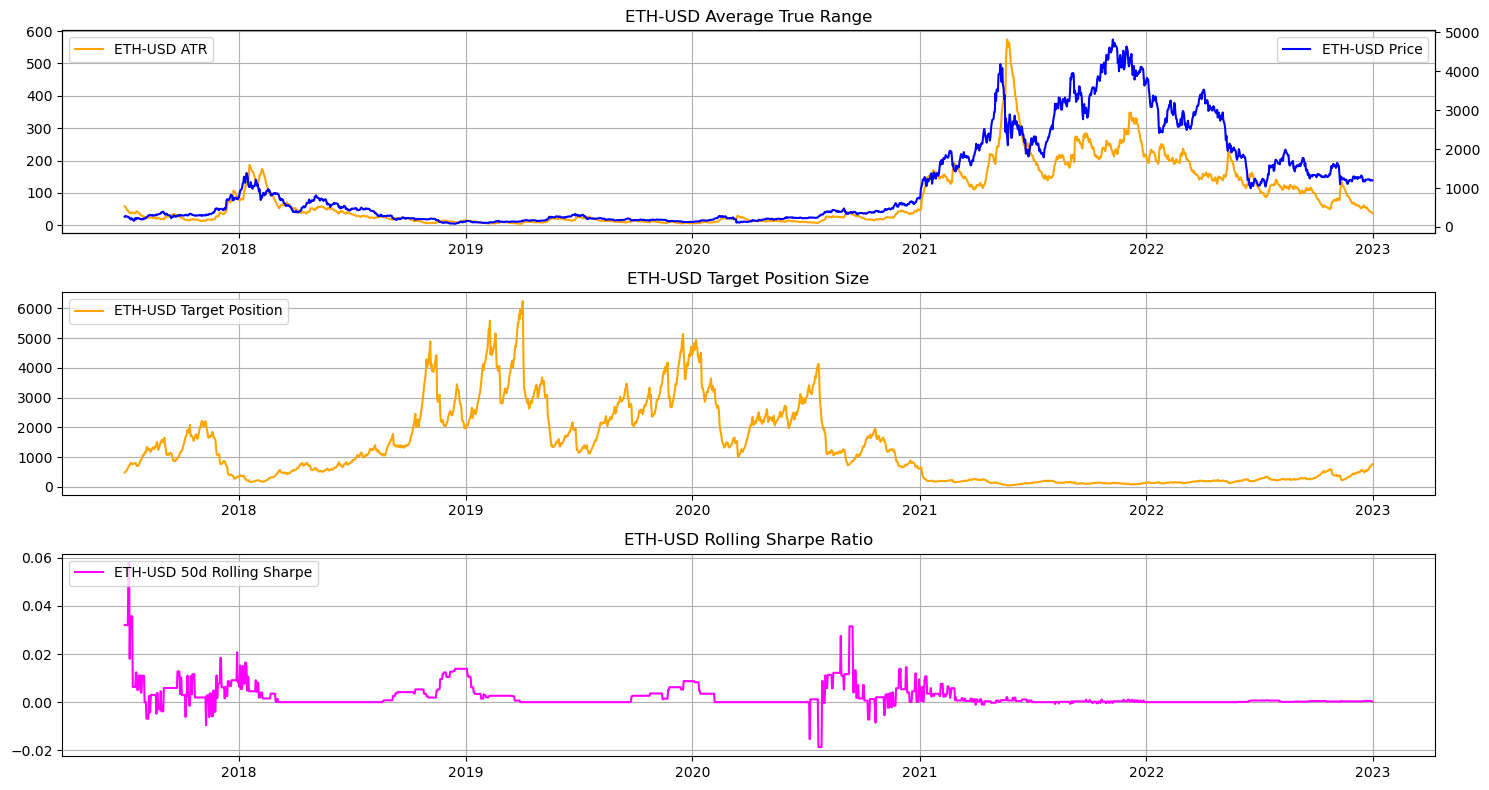

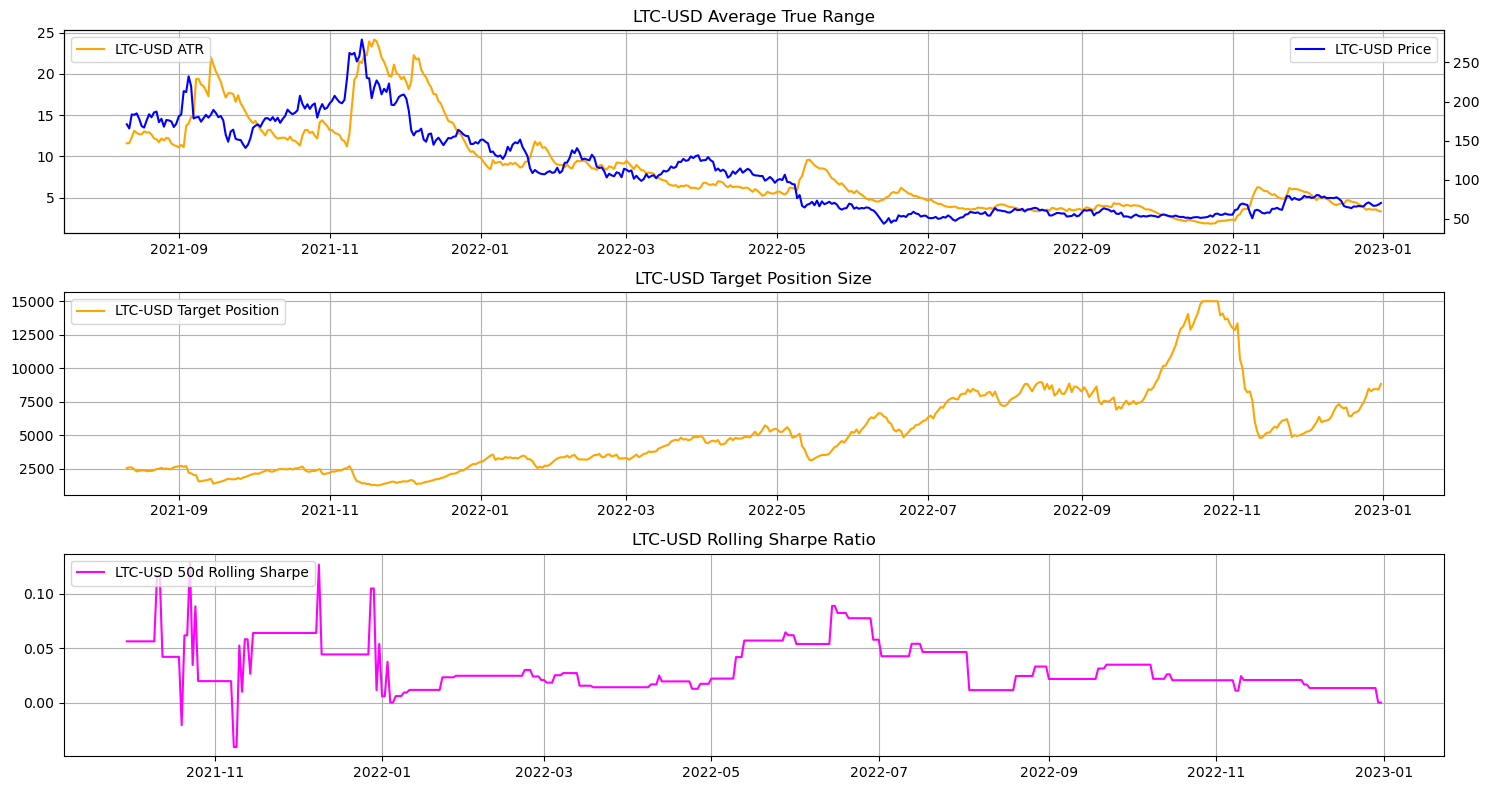

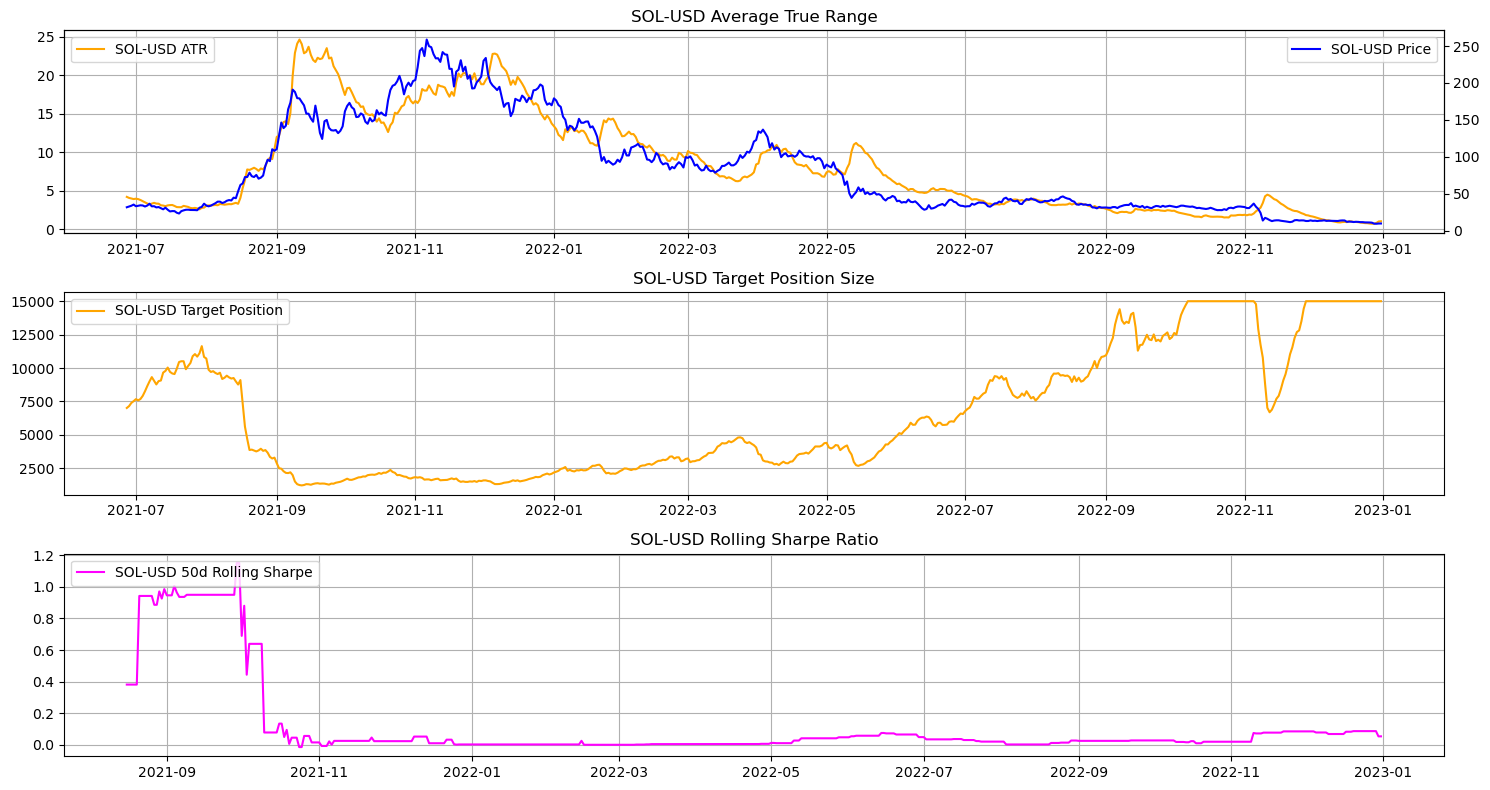

In [118]:
all_ticker_non_pyramid_df = {}
for ticker in ticker_list:
    df_strategy = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, rolling_atr_window=20, position_size_atr_multiplier=0.01,
                                                 risk_per_trade=0.1, position_sizing_pyramid_factor=False)
    short_position_event_list = ['New Short Position', 'Existing Short Position']
    df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                                  df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                                  df_strategy['portfolio_value'])
    df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()
    
    # Calculate rolling mean and standard deviation for 50-day intervals
    rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=50).mean()
    rolling_std = df_strategy['strategy_pct_returns'].rolling(window=50).std()
    
    # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
    df_strategy[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

    df_strategy = df_strategy[df_strategy.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_df[ticker] = df_strategy
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy.index, df_strategy[f'{ticker}_{rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy.index, df_strategy[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy.index, df_strategy[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy.index, df_strategy[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    annualization_factor = 365  # number of trading days in a year
    sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

BTC-USD Overall Sharpe Ratio: 0.30535857432543284
ETH-USD Overall Sharpe Ratio: 0.4944795708181023
LTC-USD Overall Sharpe Ratio: 1.1784404441520233
SOL-USD Overall Sharpe Ratio: 1.2851192034634975


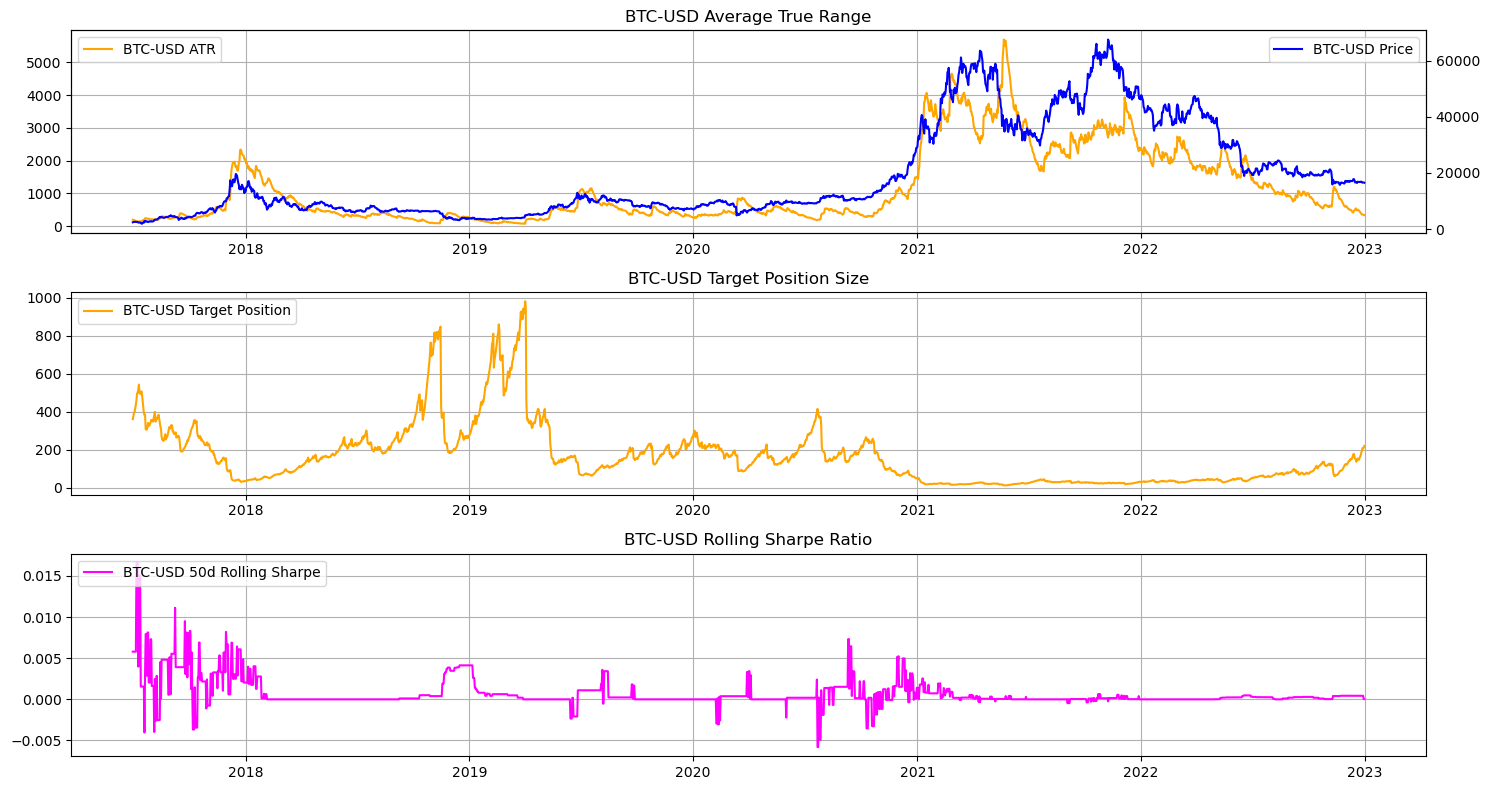

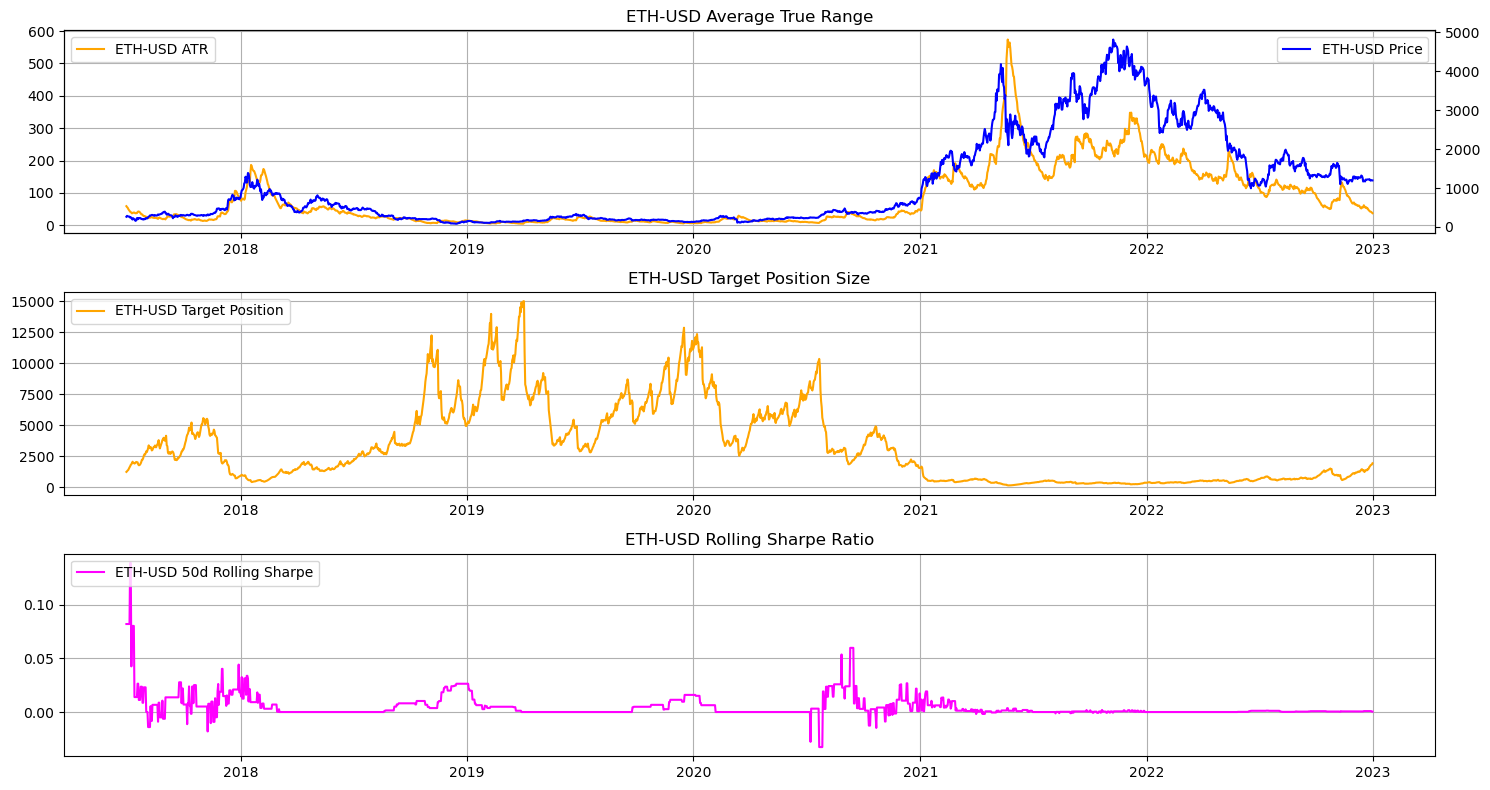

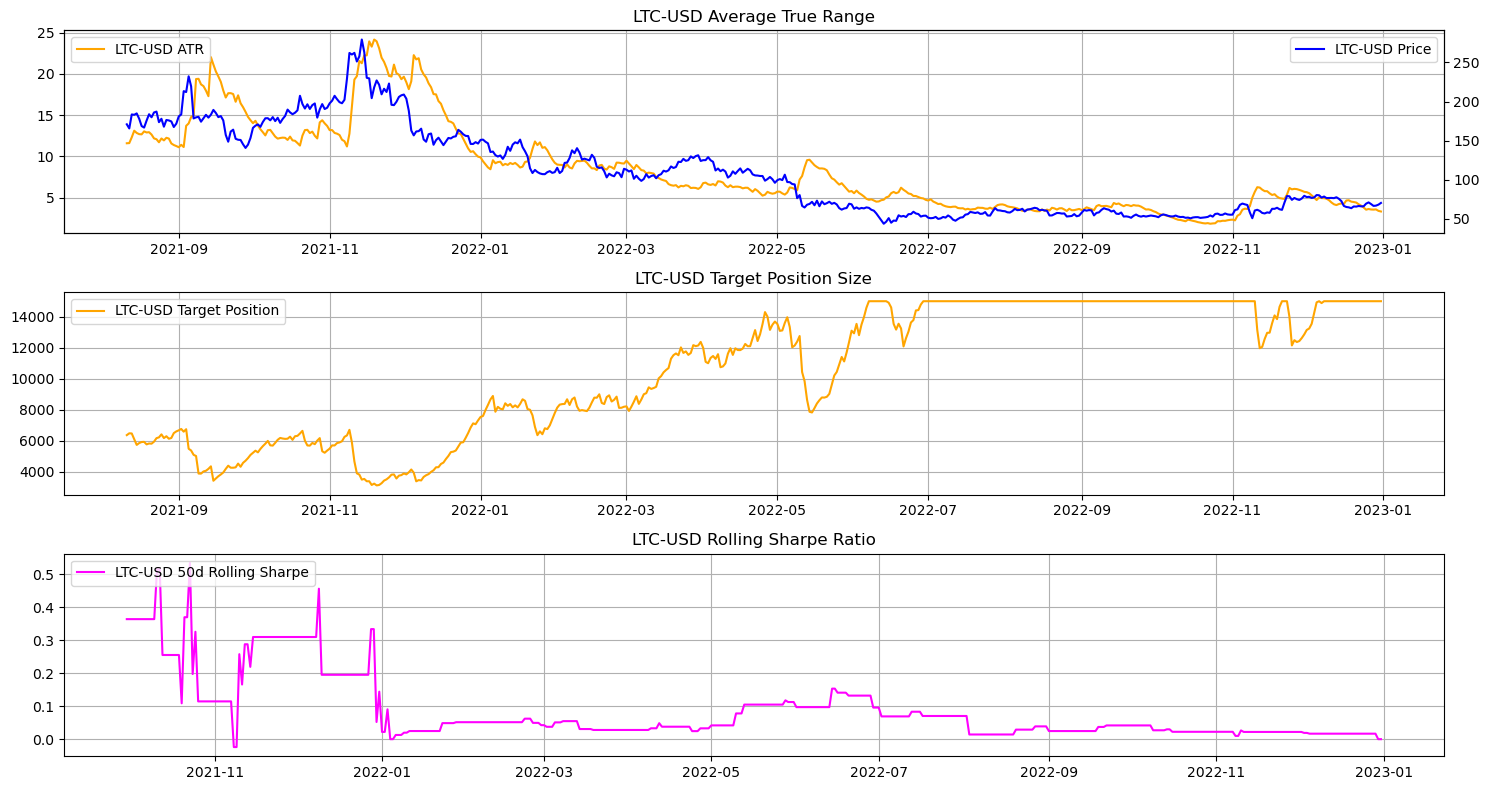

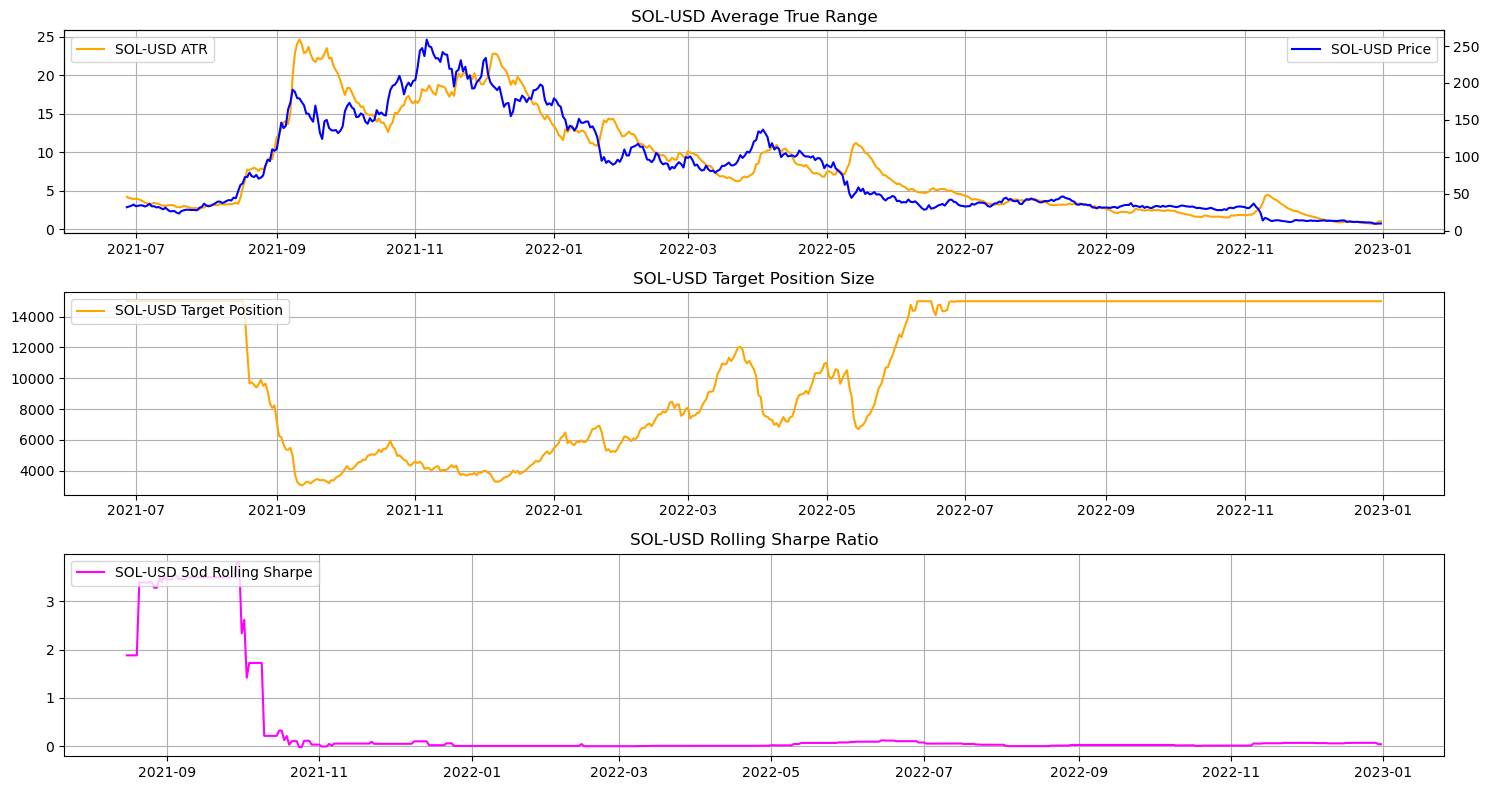

In [112]:
all_ticker_non_pyramid_df = {}
for ticker in ticker_list:
    df_strategy = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, rolling_atr_window=20, position_size_atr_multiplier=0.01,
                                                 risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    short_position_event_list = ['New Short Position', 'Existing Short Position']
    df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                                  df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                                  df_strategy['portfolio_value'])
    df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()
    
    # Calculate rolling mean and standard deviation for 50-day intervals
    rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=50).mean()
    rolling_std = df_strategy['strategy_pct_returns'].rolling(window=50).std()
    
    # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
    df_strategy[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

    df_strategy = df_strategy[df_strategy.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_df[ticker] = df_strategy
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy.index, df_strategy[f'{ticker}_{rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy.index, df_strategy[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy.index, df_strategy[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy.index, df_strategy[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    annualization_factor = 365  # number of trading days in a year
    sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
df_strategy.shape

In [ ]:
df_strategy.head(20)

In [ ]:
df_strategy.tail(20)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
close_price_col = f'{ticker}'
t_1_close_price_col = f'{ticker}_t_1'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
target_position_notional_col = f'{ticker}_target_position_notional'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_shares_col = f'{ticker}_actual_position_share_count'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
initial_capital = 15000

df_test = df_strategy.copy()
# df_test = df_test.head(200)
df_test[actual_position_notional_col] = 0.0
df_test[actual_position_entry_price_col] = 0.0
df_test[actual_position_shares_col] = 0.0
df_test['initial_capital'] = initial_capital
df_test['event'] = np.nan

In [ ]:
for i in range(1, len(df_test)):
    ## Taking a New Long position
    if (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Long Position: {df_test.index[i]}')
        # position = df[position_col][i]
        # entry_price = df[close_price_col][i]
        # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
        # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Long Position'
        
    ## Taking a New Short position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Short Position'
        
    ## Amending an Existing Long Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Amending an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Long Position'
        # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
        
    ## Amending an Existing Short Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Amending an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Short Position'
        
    ## Taking a New Long Position with an Existing Short Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Take a New Long Position with an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Long with Existing Short Position'
        
    ## Taking a New Short Position with an Existing Long Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Take a New Short Position with an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Short with Existing Long Position'
    
    ## Closing a Long Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Closing a Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i]
        df_test['event'][i] = 'Closing Long Position'
        
    ## Closing a Short Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Closing a Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])
        df_test['event'][i] = 'Closing Short Position'

    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 0):
        print(f'Other: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'No Event'

In [ ]:
initial_capital = 15000
df_test['portfolio_value'] = initial_capital * (1 + df_test['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns']).cumprod()
df_test.head(1500)

In [ ]:
i = 972
df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])

In [ ]:
df_test.tail(200)

In [ ]:
df_strategy['BTC-USD_strategy_position'] = df_strategy['BTC-USD_position_size'] * df_strategy['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']

In [ ]:
strategy_cols = ['BTC-USD', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', 'Capital', 'BTC-USD_strategy_position']

In [ ]:
trend_cols = ['BTC-USD','BTC-USD_pct_returns','BTC-USD_50_mavg','BTC-USD_90_mavg','BTC-USD_130_mavg','BTC-USD_170_mavg','BTC-USD_210_mavg','BTC-USD_250_mavg',
              'BTC-USD_trend_signal','BTC-USD_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [ ]:
sorted(df_trend.columns)

In [ ]:
df_trend[trend_cols].head(200)

In [ ]:
df_strategy[strategy_cols].head(200)

In [ ]:
df_strategy[strategy_cols].tail(200)

In [ ]:
df_strategy.head(200)

In [ ]:
df_position = position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', rolling_atr_window=20)

In [ ]:
df_position.head()

In [ ]:
df_returns.shape

In [ ]:
df_returns = pd.merge(df_returns, df_position, left_index=True, right_index=True, how='left')

In [ ]:
df_returns.shape

In [ ]:
df_returns[df_returns['BTC-USD_volatility_regime'] == 'High']#.head(20)

In [ ]:
df_returns.groupby(['BTC-USD_volatility_regime']).size()

In [ ]:
# Simulate trading logic
position = 0
entry_price = 0
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
total_capital = 15000
risk_per_trade = 0.05
stop_loss_multiplier = 2
ticker = 'BTC-USD'
rolling_atr_window = 20


for i in range(1, len(df_returns)):
    current_price = df_returns[f'{ticker}_close'].iloc[i]
    atr = df_returns[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].iloc[i]
    signal = df_returns[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'].iloc[i]

    # Calculate stop-loss distance based on ATR
    stop_loss_distance = stop_loss_multiplier * atr
    risk_per_unit = current_price - (current_price - stop_loss_distance)

    # Calculate position size based on the risk
    position_size = (total_capital * risk_per_trade) / risk_per_unit

    if signal == 1 and position == 0:
        # Buy signal: go long
        position = position_size
        entry_price = current_price
        print(f"Buy: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == -1 and position > 0:
        # Sell signal: exit long position
        print(f"Sell: Closing long position at {current_price:.2f} USD")
        position = 0  # Reset position

    elif signal == -1 and position == 0:
        # Short signal: go short
        position = -position_size
        entry_price = current_price
        print(f"Short: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == 1 and position < 0:
        # Exit short position if a buy signal occurs
        print(f"Buy to cover: Closing short position at {current_price:.2f} USD")
        position = 0  # Reset position

In [ ]:
df_returns.head(20)

In [ ]:
df_atr.head(20)